In [1]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, RFE, VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE
import pandas as pd 
import numpy as np 
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
%matplotlib inline

# Methods

In [2]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "Mutual Information"
    
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

def preprocess_data_frame(data_frame, columns):
    """
    Dummifying and encoding variables of dataframe, droping rows with NAN values
    :param data_frame: A pandas DataFrame to be processed
    pandas DataFrame
    :param columns: List of column names of categorical variables 
    :returns data_frame: encoded variable DataFrame
    """
    data_frame = data_frame.dropna()
    data_frame = data_frame.reset_index(drop=True)
    
    for col in columns:
#         print(data_frame[col])
        data_frame[col] = encode_variable(data_frame[col])
#         print(data_frame[col])
    data_frame = pd.get_dummies(data_frame)
    return data_frame
    
def encode_variable(series):
    """
    Encoding categorical variables to numericial values
    :param series: A pandas Series with categorical values
    pandas DataFrame
    :returns data_frame: encoded variable DataFrame
    """
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(series)
    print(list(le.classes_))
    print(set(le.transform(series))) 
    data_frame = pd.DataFrame({
        series.name: le.transform(series)
    })
    return data_frame
    
def split_dataframe(data_frame, target):
    """
    Split dataframe to predictors and target
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :returns DataFrames: X (predictors) and y (target) dataframes 
    """
    X = data_frame.drop([target], axis=1)
    y = encode_variable(data_frame[target])
    return X, y 

def get_features_variance_threshold(data_frame,target="gender", threshold=0.2):
    """
    Returns list of features with a variance above the specified threshold
    :param data_frame: A pandas dataFrame with the training data
    :param threshold: float value between 0 and 1 
    :returns feature_scores: list of features
    """
    if target in data_frame.columns:
        data_frame = data_frame.drop([target], axis=1)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
#     print(feat_ix_keep)
    return data_frame.columns[feat_ix_keep]

def get_features_univariate(data_frame, k=5, linear=True, target="gender"):
    """
    Returns list of features selected using the specified univariate method
    :param data_frame: A pandas dataFrame with the training data
    :param k: top k features to select  
    :returns data_frame: with selected features
    """
    df = show_kbest(data_frame,target=target,linear_rel=linear, k=k)
    df = df[df["Support"] == True]
    columns = df["Attribute"].values
    return columns

def get_features_rfe(data_frame,model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame.drop("gender", axis=1)
    y = data_frame["gender"]
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return list(df[df["support"] == True]["feature"])

    
    
def under_sample(X,y):
    """ Returns resampled features and labels
    :param X: Features data frame
    :param y: Label data frame
    :return X_resampled, y_resampled: Numpy features array and corresponding lable array
    """
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_sample(X, y)
    print(sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

def generate_classification_report(X_train, X_test, y_train, y_test, model):
    """ Prints classification report
    :param X: Features data frame
    :param y: Label data frame
    :param model: Sklearn model object
    """
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#     y_test = list(np.array(y_test).flatten())
#     y_train = list(np.array(y_train).flatten())
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    target_names = ['female', 'male']
    mean = cross_val_score(model, X_test, y_test, cv=10, scoring="accuracy").mean()
    var = cross_val_score(model, X_test, y_test, cv=10, scoring="accuracy").var()
#     print("Cross Validated Accuracy: mean - {}, var - {}".format(mean, var))
    print("Accuracy Score: {} Var: {}".format(mean, var))
    print("\nConfusion Matrix:\n")
    print(confusion_matrix(y_test, pred))
    print("\nClassification Report:\n")
    print(classification_report(y_test, pred, target_names=target_names))
    
def change_of_evaluation_rfe(X_train, X_test,y_train,y_test,model, metric="precision"):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    :return num_features: Returns the top k features to be selected
    """
    base = pd.concat([pd.concat([X_train,X_test]), pd.concat([y_train,y_test])], axis=1)
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    score = []
    for k in range(len(X.columns),0,-1):
        columns = get_features_rfe(base,model,k)
        X_tr = X_train[columns]
        X_te = X_test[columns]

        model.fit(X_tr, y_train)
        mean = cross_val_score(model, X_te, y_test, cv=10, scoring=metric).mean()
        variance = cross_val_score(model, X_te, y_test, cv=10).var()

        score.append([k, mean, variance])

    df = pd.DataFrame(score, columns=["num_features", "mean","variance"])
    sns.pointplot(df["num_features"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["num_features"]].values[0][0]

def change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,model, metric="precision", linear=True):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param linear: If true > F-score if false > mutual information
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    :return num_features: Returns the top k features to be selected
    """
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    data = pd.concat([X,y], axis=1)
    score = []
    for k in range(len(X.columns),0,-1):
        df = show_kbest(data,"gender",linear_rel=linear, k=k)
        df = df[df["Support"] == True]
        columns = df["Attribute"].values
        X_tr = X_train[columns]
        X_ts = X_test[columns]

        model.fit(X_tr, y_train)
        mean = cross_val_score(model, X_ts, y_test, cv=10, scoring=metric).mean()
        variance = cross_val_score(model, X_ts, y_test, cv=10).var()

        score.append([k, mean, variance])

    df = pd.DataFrame(score, columns=["num_features", "mean","variance"])
    sns.pointplot(df["num_features"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["num_features"]].values[0][0]

def change_of_evaluation_variance_threshold(X_train, X_test, y_train, y_test,model,metric="precision"):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    """
    lst = list(np.arange(0.0, 1.0, 0.1))
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    score = []
    for k in lst:
        features = get_features_variance_threshold(X, threshold=k)
        
        X_train = X_train[features]
        X_test = X_test[features]
        
#         print("Variance: {} - features: {}".format(k,features))

        model.fit(X_train, y_train)
        mean = cross_val_score(model, X_test, y_test, cv=10).mean()
        variance = cross_val_score(model, X_test, y_test, cv=10).var()
        score.append([k, mean, variance])
#     print(score)
    df = pd.DataFrame(score, columns=["variance", "mean", "std"])
    sns.pointplot(df["variance"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["variance"]].values[0][0]
    
def full_report(X_train, X_test, y_train, y_test, model):
    """ Prints classification report for model over different feature selection models
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn object
    """
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    
    base = pd.concat([X,y], axis=1)
    print("""###############################################################""")
    print("""Feature Selection: F-SCORE: \n""")
    k = change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,
                                                              model, metric="accuracy")
    features = get_features_univariate(base, k=k, linear=True)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    print("""###############################################################""")
    print("""Feature Selection: MUTUAL INFORMATION: \n""")

    k = change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,
                                                              model,linear=False, metric="accuracy")
    features = get_features_univariate(base, k=k, linear=False)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    print("""###############################################################""")
    print("""Feature Selection: Variance Threshold: \n""")
    v = change_of_evaluation_variance_threshold(X_train, X_test, y_train, y_test,model, metric="accuracy")
#     print(v)
    features = get_features_variance_threshold(base,threshold=v)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    
    print("""###############################################################""")
    print("""Feature Selection: RFE: \n""")
    k = change_of_evaluation_rfe(X_train, X_test, y_train, y_test,
                                 model,metric='accuracy')
    features = get_features_rfe(base,model, k=k)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, model)
    
def normalize(data_frame, columns):
    """
    Normalizing (loged) column values
    :param data_frame: A pandas DataFrame to be processed
    :param columns: List of column names of categorical variables 
    :returns data_frame: DataFrame with normalizedcolumns
    """    
    for col in columns:
        data_frame[col] = log_colum_values(data_frame[col])
    return data_frame

def log_colum_values(series_col):
    """
    Normalizing (loged) column values
    :param series: Column of dataframe 
    :returns np array: DataFrame with normalizedcolumns
    """    
    min_val = series_col.min()
    values = [log_value(v, min_val)for v in series_col.values]
    return values

def log_value(x, min_val):
    """
    Logs a value, replacing -inf with 0 and handling negative values
    :param x: value
    :param min_val: min value in list 
    :returns value: loged numerical value
    """    
    if x>0:
        return np.log(x)
    if np.log(x) == -inf:
        return 0 
    if x < 0:
#         print("na")
        return np.log(x + 1 - min_val)

def plot_loged(data, col_name):
    x= np.log(data[col_name])
    x = x[~np.isnan(x)]
    x = x[x != np.inf]
    x = x[x != -np.inf]
    sns.distplot(x)

In [3]:
def over_sample(X,y):
    """
    Does the hybrid oversampling with SMOTE
    :param X: Dataframe with predictor atributes
    :param y: Dataframe with labels
    :return X_resampled, y_resampled:
    """
    sm = SMOTE(random_state=42)
    X,y = sm.fit_sample(X, y)
    print(X.shape, y.shape)
    return X,y

def train_test_dfs(X,y,test_size=0.2):
    """
    Returns train, test dataframees
    :parma X: data frame with predictor atributes 
    :parma y: data frame with labels 
    :parma test_size: fraction of data set to be assigned to the test set
    :return X_train, X_test, y_train, y_test:
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    y_train = pd.DataFrame(y_train, columns=y.columns)
    y_test = pd.DataFrame(y_test, columns=y.columns)
    return X_train, X_test, y_train, y_test

def evaluate_model(estimator, X_train, X_test, y_train, y_test): 
    """
    Prints accuracy, confusion matrix and classification report
    """
    target_names = ['female', 'male']
    estimator.fit(X_train,y_train)
    print(accuracy_score(y_test, estimator.predict(X_test)))
    print(confusion_matrix(y_test, estimator.predict(X_test)))
    print(classification_report(y_test, estimator.predict(X_test), target_names=target_names))
    
def get_ac_pr_re_f1(estimator, X,y):
    """
    Returns:
    Accuracy, Precission, Recall, F1-Score
    """
    estimator.fit(X_train,y_train)
    predict = estimator.predict(X_test)
    acc = cross_val_score(estimator, X,y,scoring="accuracy", cv=10).mean()
    re = cross_val_score(estimator, X,y,scoring="recall", cv=10).mean()
    pr = cross_val_score(estimator, X,y,scoring="precision", cv=10).mean()
    f1 = cross_val_score(estimator, X,y,scoring="f1", cv=10).mean()
    return acc,pr,re,f1

def model_comparison_df(estimator_dict, X,y):
    """
    Returns table with model performance comparisson
    """
    lst = []
    for k,v in estimator_dict.items():
        acc, pr, re, f1 = get_ac_pr_re_f1(v, X,y)
        lst.append([k, acc, pr, re, f1])
    return pd.DataFrame(lst, columns=["Algorithm", "Accuracy", "Precision", "Recall", "F1"])

def print_latex(df, col_format="|c|c|c|c|c|"):
    """ Prints the latex syntax equivalent to the passed dataframe
    :param df: Pandas dataframe 
    :col_format : String indicating the format of columns
    """
    df = df.round(2)
    latex = df.to_latex(column_format=col_format, index=False).replace('toprule',
                                            "hline").replace('midrule',
                                            "hline").replace('bottomrule',
                                            "hline").replace("\\\\\n",
                                            "\\\\\n\\hline").replace("\hline\hline","\hline")
    print(latex)

In [4]:
# get_ac_pr_re_f1(r_forest,X_over,y_over)

# Load the data

In [5]:
data = pd.read_pickle("../data/final_sets/countries/model_large/2016_german")

In [6]:
data.head()

,gender,entered,efficiency,eig_central,in_degree,k_core,out_degree,views,age,is_alive,...,lyr,phs,act,ply,other_o,party1,party2,party3,other_p,year_interval
7,male,2011,1.000,2.021104e-19,0,1,1,1652.0,70,no,...,0,0,0,0,1,0,0,0,1,3
113,male,2012,0.920,2.530002e-05,2,5,3,2376.0,73,no,...,0,0,0,0,1,0,0,0,1,3
127,male,2009,0.625,-1.456437e-19,0,4,4,32143.0,60,no,...,0,0,0,0,1,0,0,0,1,2
132,male,2009,1.000,9.096369e-08,1,2,1,2268.0,71,no,...,0,0,0,0,1,0,0,0,1,2
158,male,2011,0.750,7.461692e-04,2,4,2,19536.0,48,no,...,0,0,0,0,1,0,0,0,1,3


In [7]:
# data = data.drop(["is_alive_no","distance_delta"],axis=1)

In [8]:
data.shape

(1325, 32)

In [9]:
data.gender.value_counts()

male      1136
female     171
Name: gender, dtype: int64

# Preprocesing

In [10]:
data = preprocess_data_frame(data, ["gender"])
# data["gender"]

['female', 'male']
{0, 1}


In [11]:
X,y=split_dataframe(data,"gender")

[0, 1]
{0, 1}


In [12]:
X.head()

,entered,efficiency,eig_central,in_degree,k_core,out_degree,views,age,distance_birth,distance_death,...,party1,party2,party3,other_p,is_alive_no,is_alive_unknown,is_alive_yes,year_interval_1,year_interval_2,year_interval_3
0,2011,1.000,2.021104e-19,0,1,1,1652.0,70,142,72,...,0,0,0,1,1,0,0,0,0,1
1,2012,0.920,2.530002e-05,2,5,3,2376.0,73,128,55,...,0,0,0,1,1,0,0,0,0,1
2,2009,0.625,-1.456437e-19,0,4,4,32143.0,60,114,53,...,0,0,0,1,1,0,0,0,1,0
3,2009,1.000,9.096369e-08,1,2,1,2268.0,71,103,31,...,0,0,0,1,1,0,0,0,1,0
4,2011,0.750,7.461692e-04,2,4,2,19536.0,48,166,117,...,0,0,0,1,1,0,0,0,0,1


In [13]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# y_test = list(np.array(y_test.values).flatten())
# y_train = list(np.array(y_train.values).flatten())

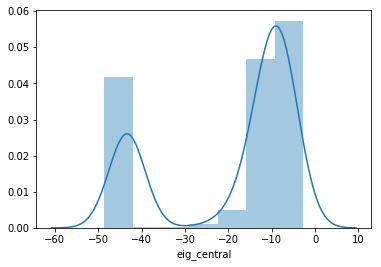

In [14]:
plot_loged(data, "eig_central")

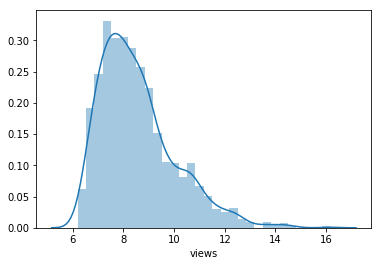

In [15]:
plot_loged(data, "views")

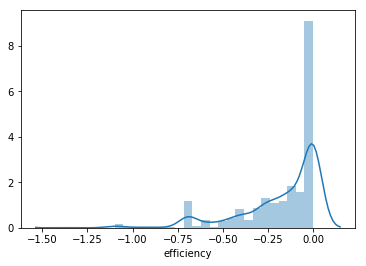

In [16]:
plot_loged(data, "efficiency")

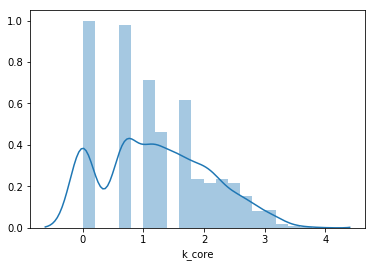

In [17]:
plot_loged(data, "k_core")

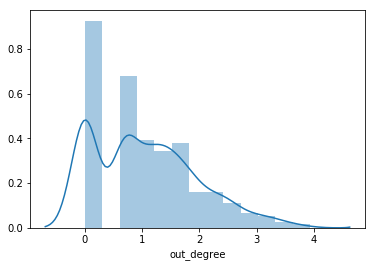

In [18]:
plot_loged(data, "out_degree")

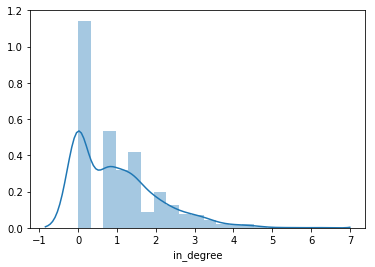

In [19]:
plot_loged(data, "in_degree")

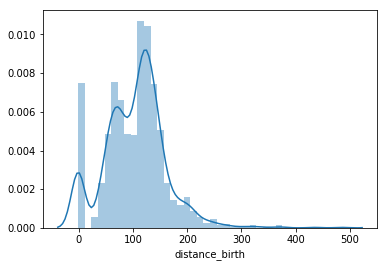

In [20]:
sns.distplot(data["distance_birth"])

# Algorithms

In [21]:
# SVM
s_vm = svm.SVC()
# Logistic regression
log_reg = LogisticRegression()
# Decision Tree
d_tree = tree.DecisionTreeClassifier()
# Random Forest
r_forest = RandomForestClassifier()

estimator_dict = {
    "SVM": s_vm,
    "Logistic Regression": log_reg,
    "Decision Tree": d_tree,
    "Random Forest": r_forest
}

# Oversampling 

In [22]:
X_over, y_over = over_sample(X,y)
X_over = pd.DataFrame(X_over, columns=X.columns)
y_over = pd.DataFrame(y_over, columns=["gender"])
y_over["gender"].value_counts()

(2272, 35) (2272,)


1    1136
0    1136
Name: gender, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = train_test_dfs(X_over,y_over)

In [24]:
# y_train["gender"].value_counts()

In [25]:
X_train_norm = normalize(X_train, columns=["eig_central","in_degree","k_core","out_degree","views"])
X_test_norm = normalize(X_test, columns=["eig_central","in_degree","k_core","out_degree","views"])

## SVM

In [26]:
cross_val_score(s_vm,X_over,y_over,scoring='accuracy',cv=10)

array([0.73245614, 0.71929825, 0.70175439, 0.68859649, 0.6754386 ,
       0.73245614, 0.74778761, 0.70353982, 0.66814159, 0.71681416])

## Logistic Regression

In [27]:
cross_val_score(log_reg,X_over,y_over,scoring='accuracy',cv=10)

array([0.70175439, 0.72807018, 0.72807018, 0.6754386 , 0.70175439,
       0.72368421, 0.77876106, 0.75663717, 0.65929204, 0.65929204])

In [28]:
evaluate_model(log_reg, X_train, X_test, y_train, y_test)

0.789010989010989
[[192  37]
 [ 59 167]]
             precision    recall  f1-score   support

     female       0.76      0.84      0.80       229
       male       0.82      0.74      0.78       226

avg / total       0.79      0.79      0.79       455



## Decision Tree 

In [29]:
cross_val_score(d_tree,X_over,y_over,scoring='accuracy',cv=10)

array([0.60964912, 0.79824561, 0.94298246, 0.88596491, 0.93859649,
       0.92982456, 0.9380531 , 0.92035398, 0.88938053, 0.86725664])

In [30]:
evaluate_model(d_tree, X_train, X_test, y_train, y_test)

0.8967032967032967
[[216  13]
 [ 34 192]]
             precision    recall  f1-score   support

     female       0.86      0.94      0.90       229
       male       0.94      0.85      0.89       226

avg / total       0.90      0.90      0.90       455



## Random Forest

In [31]:
cross_val_score(r_forest,X_over,y_over,scoring='accuracy',cv=10)

array([0.6754386 , 0.81578947, 0.93421053, 0.92982456, 0.95614035,
       0.95614035, 0.97787611, 0.95132743, 0.9380531 , 0.86283186])

In [32]:
evaluate_model(r_forest, X_train, X_test, y_train, y_test)

0.9032967032967033
[[210  19]
 [ 25 201]]
             precision    recall  f1-score   support

     female       0.89      0.92      0.91       229
       male       0.91      0.89      0.90       226

avg / total       0.90      0.90      0.90       455



## Comparison

In [33]:
df = model_comparison_df(estimator_dict, X_over,y_over)

In [34]:
df

,Algorithm,Accuracy,Precision,Recall,F1
0,SVM,0.708628,0.634308,0.987665,0.772390
1,Logistic Regression,0.711275,0.770870,0.601203,0.672675
2,Decision Tree,0.873797,0.909432,0.861652,0.880733
3,Random Forest,0.904607,0.928456,0.896887,0.903008


In [35]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
           Algorithm &  Accuracy &  Precision &  Recall &    F1 \\
\hline
                 SVM &      0.71 &       0.63 &    0.99 &  0.77 \\
\hline Logistic Regression &      0.71 &       0.77 &    0.60 &  0.67 \\
\hline       Decision Tree &      0.87 &       0.91 &    0.86 &  0.88 \\
\hline       Random Forest &      0.90 &       0.93 &    0.90 &  0.90 \\
\hline
\end{tabular}



# Undersampling

In [36]:
X_under, y_under = under_sample(X,y)
X_under = pd.DataFrame(X_under, columns=X.columns)
y_under = pd.DataFrame(y_under, columns=["gender"])
# base = pd.concat([X_resampled, y_resampled], axis=1)
# base.head()

[(0, 171), (1, 171)]


In [37]:
X_train, X_test, y_train, y_test = train_test_dfs(X_under,y_under)

In [38]:
X_train_norm = normalize(X_train, columns=["eig_central","in_degree","k_core","out_degree","views"])
X_test_norm = normalize(X_test, columns=["eig_central","in_degree","k_core","out_degree","views"])

## SVM

In [39]:
evaluate_model(s_vm, X_train, X_test, y_train, y_test)

0.6376811594202898
[[19 17]
 [ 8 25]]
             precision    recall  f1-score   support

     female       0.70      0.53      0.60        36
       male       0.60      0.76      0.67        33

avg / total       0.65      0.64      0.63        69



## Logistic Regression

In [40]:
evaluate_model(log_reg, X_train, X_test, y_train, y_test)

0.6666666666666666
[[24 12]
 [11 22]]
             precision    recall  f1-score   support

     female       0.69      0.67      0.68        36
       male       0.65      0.67      0.66        33

avg / total       0.67      0.67      0.67        69



## Decision Tree 

In [41]:
evaluate_model(d_tree, X_train, X_test, y_train, y_test)

0.5362318840579711
[[21 15]
 [17 16]]
             precision    recall  f1-score   support

     female       0.55      0.58      0.57        36
       male       0.52      0.48      0.50        33

avg / total       0.54      0.54      0.54        69



## Random Forest

In [42]:
evaluate_model(r_forest, X_train, X_test, y_train, y_test)

0.6086956521739131
[[26 10]
 [17 16]]
             precision    recall  f1-score   support

     female       0.60      0.72      0.66        36
       male       0.62      0.48      0.54        33

avg / total       0.61      0.61      0.60        69



## Comparison

In [43]:
df = model_comparison_df(estimator_dict, X_under,y_under)

In [44]:
df

,Algorithm,Accuracy,Precision,Recall,F1
0,SVM,0.529248,0.515541,0.988235,0.677476
1,Logistic Regression,0.719281,0.742953,0.684314,0.707769
2,Decision Tree,0.608170,0.619377,0.625490,0.616664
3,Random Forest,0.686928,0.683762,0.619608,0.650357


In [45]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
           Algorithm &  Accuracy &  Precision &  Recall &    F1 \\
\hline
                 SVM &      0.53 &       0.52 &    0.99 &  0.68 \\
\hline Logistic Regression &      0.72 &       0.74 &    0.68 &  0.71 \\
\hline       Decision Tree &      0.61 &       0.62 &    0.63 &  0.62 \\
\hline       Random Forest &      0.69 &       0.68 &    0.62 &  0.65 \\
\hline
\end{tabular}



# Countries

In [46]:
country_dict = {
    "USA": "american",
    "Germany": "german",
    "France": "french",
    "Great Britain": "british",
    "Russia": "russian"
} 

In [47]:
def compare_countries_df(country_dict, path, year, estimator):
    lst = []
    for k,v in country_dict.items():
        df = pd.read_pickle(path+str(year)+"_"+v)
        df = preprocess_data_frame(df, ["gender"])
        if "is_alive_no" in df.columns and "distance_delta" in df.columns and "other_p" in df.columns:
            df = df.drop(["is_alive_no","distance_delta","other_p"],axis=1)
        X,y=split_dataframe(df,"gender")
        X_over, y_over = over_sample(X,y)
        X_over = pd.DataFrame(X_over, columns=X.columns)
        y_over = pd.DataFrame(y_over, columns=["gender"])
        y_over["gender"].value_counts()
        acc, pr, re, f1 = get_ac_pr_re_f1(estimator, X_over,y_over)
        lst.append([k, acc, pr, re, f1])
    return pd.DataFrame(lst, columns=["Country", "Accuracy", "Precision", "Recall", "F1"])

In [48]:
df = compare_countries_df(country_dict, "../data/final_sets/countries/model_large/", 2016, r_forest)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(8030, 32) (8030,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2272, 32) (2272,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2422, 32) (2422,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(792, 32) (792,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(1032, 32) (1032,)


In [49]:
df

,Country,Accuracy,Precision,Recall,F1
0,USA,0.871185,0.905654,0.903334,0.885991
1,Germany,0.897101,0.931042,0.895117,0.903922
2,France,0.898215,0.934765,0.895062,0.912862
3,Great Britain,0.872981,0.932244,0.888846,0.894395
4,Russia,0.947964,0.963221,0.959427,0.962474


In [50]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
       Country &  Accuracy &  Precision &  Recall &    F1 \\
\hline
           USA &      0.87 &       0.91 &    0.90 &  0.89 \\
\hline       Germany &      0.90 &       0.93 &    0.90 &  0.90 \\
\hline        France &      0.90 &       0.93 &    0.90 &  0.91 \\
\hline Great Britain &      0.87 &       0.93 &    0.89 &  0.89 \\
\hline        Russia &      0.95 &       0.96 &    0.96 &  0.96 \\
\hline
\end{tabular}



In [51]:
df = compare_countries_df(country_dict, "../data/final_sets/countries/model/", 2016, r_forest)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(8030, 18) (8030,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2272, 18) (2272,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2422, 18) (2422,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(792, 18) (792,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(1032, 18) (1032,)


In [52]:
df

,Country,Accuracy,Precision,Recall,F1
0,USA,0.866575,0.903724,0.894874,0.885541
1,Germany,0.895785,0.928716,0.874895,0.904192
2,France,0.901917,0.930372,0.887664,0.912897
3,Great Britain,0.876827,0.912705,0.871154,0.900215
4,Russia,0.938216,0.956768,0.932278,0.951802


In [53]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
       Country &  Accuracy &  Precision &  Recall &    F1 \\
\hline
           USA &      0.87 &       0.90 &    0.89 &  0.89 \\
\hline       Germany &      0.90 &       0.93 &    0.87 &  0.90 \\
\hline        France &      0.90 &       0.93 &    0.89 &  0.91 \\
\hline Great Britain &      0.88 &       0.91 &    0.87 &  0.90 \\
\hline        Russia &      0.94 &       0.96 &    0.93 &  0.95 \\
\hline
\end{tabular}



In [54]:
def important_features(X,y, estimator):
    estimator.fit(X,y)
    df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": estimator.feature_importances_
    })
    return df.sort_values(by="Importance",ascending=False)

def compare_features_df(country_dict, path, year, estimator):
    lst = []
    for k,v in country_dict.items():
        df = pd.read_pickle(path+str(year)+"_"+v)
        df = preprocess_data_frame(df, ["gender"])
        if "is_alive_no" in df.columns and "distance_delta" in df.columns and "other_p" in df.columns:
            df = df.drop(["is_alive_no","distance_delta","other_p"],axis=1)
        X,y=split_dataframe(df,"gender")
        X_over, y_over = over_sample(X,y)
        X_over = pd.DataFrame(X_over, columns=X.columns)
        y_over = pd.DataFrame(y_over, columns=["gender"])
        y_over["gender"].value_counts()
        lst.append([k,important_features(X_over, y_over, estimator)])
    return lst

In [55]:
x = compare_features_df(country_dict, "../data/final_sets/countries/model_large/", 2016, r_forest)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(8030, 32) (8030,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2272, 32) (2272,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2422, 32) (2422,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(792, 32) (792,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(1032, 32) (1032,)


In [56]:
x[1][1].reset_index(drop=True)

,Feature,Importance
0,is_alive_yes,0.195619
1,distance_birth,0.108500
2,distance_death,0.066209
3,age,0.058078
4,views,0.047738
5,party_num,0.046052
6,party1,0.039861
7,year_interval_3,0.039731
8,entered,0.039604
9,year_interval_2,0.035565


In [57]:
# lst = [x[1][1].reset_index(drop=True),x[2][1].reset_index(drop=True),x[3][1].reset_index(drop=True),x[4][1].reset_index(drop=True)]
# ,x[3][1],x[4][1]/
lst = [x[0][1],x[1][1],x[2][1],x[3][1],x[4][1]]

In [58]:
df.columns

Index(['Country', 'Accuracy', 'Precision', 'Recall', 'F1'], dtype='object')

In [59]:
df = pd.concat(lst, axis=1)
# atrs = df.Feature
atrs = df.take([0], axis=1)
atrs = atrs.replace({
    "wrt":"writer",
    "sci":"scientist",
    "jur":"journalist",
    "eco":"economist",
    "hst":"historian",
    "spo":"athleate",
    "lyr":"lawyer",
    "phs":"physician",
    "act":"actor",
    "distance_birth":"d_birth",
    "distance_death":"d_death",
    "nationality_num":"nationalities",
    "occupation_num":"occupations",
    "year_interval_1":"interval_1",
    "year_interval_2":"interval_2",
    "year_interval_3":"interval_3",
    "is_alive_unknown":"alive_unknown",
    "is_alive_yes":"is_alive"
})
us = df.take([1], axis=1)
de = df.take([3], axis=1)
fr = df.take([5], axis=1)
gb = df.take([7], axis=1)
ru = df.take([9], axis=1)

# df = df.drop(df.columns[2],axis=1)
# table = pd.DataFrame({
#     "Attribute": atrs,
#     "USA": us,
#     "Germany": de,
#     "France":fr,
#     "Great Britain": gb,
#     "Russia": ru
# })
# table["Attribute"] = atrs
# table["USA"] = us
# table["Germany"] = de
# table["France"] = fr
# table["Great Britain"] = gb
# table["Russia"] = ru
table = pd.concat([atrs, us,de,fr,gb,ru],axis=1)
table

,Feature,Importance,Importance,Importance,Importance,Importance
0,entered,0.052305,0.039604,0.078307,0.044835,0.067444
1,efficiency,0.040219,0.035459,0.028054,0.056187,0.030614
2,eig_central,0.033399,0.031906,0.030995,0.041824,0.038275
3,in_degree,0.043697,0.030563,0.050781,0.063684,0.071424
4,k_core,0.036222,0.026588,0.034966,0.049821,0.044312
5,out_degree,0.038110,0.034250,0.043503,0.051579,0.048370
6,views,0.077907,0.047738,0.050124,0.107456,0.105345
7,age,0.053846,0.058078,0.064946,0.033080,0.068013
8,d_birth,0.104301,0.108500,0.102308,0.050566,0.054168
9,d_death,0.041578,0.066209,0.046904,0.025920,0.024230


In [60]:
# pd.concat(lst, axis=1).head(10)

In [61]:
# print_latex(pd.concat(lst, axis=1).head(10))

In [62]:
# us = x[0][1]["USA"] = x[0][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# de = x[1][1]["Germany"] = x[1][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# fr = x[2][1]["France"] = x[2][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# gb = x[3][1]["Great Britain"] = x[3][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# ru = x[4][1]["Russia"] = x[4][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# lst = [us,de,fr,gb,ru]

In [63]:
# us = x[0][1]["USA"] = x[0][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# de = x[1][1]["Germany"] = x[1][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# fr = x[2][1]["France"] = x[2][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# gb = x[3][1]["Great Britain"] = x[3][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# ru = x[4][1]["Russia"] = x[4][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# lst = [us,de,fr,gb,ru]

In [64]:
# df = pd.concat(lst,axis=1)
# df.columns = ["USA", "Germany", "France", "Great Britain", "Russia"]
# print_latex(df.head(10))

In [65]:
print_latex(table)

\begin{tabular}{|c|c|c|c|c|}
\hline
       Feature &  Importance &  Importance &  Importance &  Importance &  Importance \\
\hline
       entered &        0.05 &        0.04 &        0.08 &        0.04 &        0.07 \\
\hline    efficiency &        0.04 &        0.04 &        0.03 &        0.06 &        0.03 \\
\hline   eig\_central &        0.03 &        0.03 &        0.03 &        0.04 &        0.04 \\
\hline     in\_degree &        0.04 &        0.03 &        0.05 &        0.06 &        0.07 \\
\hline        k\_core &        0.04 &        0.03 &        0.03 &        0.05 &        0.04 \\
\hline    out\_degree &        0.04 &        0.03 &        0.04 &        0.05 &        0.05 \\
\hline         views &        0.08 &        0.05 &        0.05 &        0.11 &        0.11 \\
\hline           age &        0.05 &        0.06 &        0.06 &        0.03 &        0.07 \\
\hline       d\_birth &        0.10 &        0.11 &        0.10 &        0.05 &        0.05 \\
\hline       d\_death & 